# Tutorial 9: Dynamic string

In this tutorial we will learn how to describe the motion of an oscillating axially deformed string. Here, we will use the FEM to solve a geometrically nonlinear structure subject to gravity loading in a dynamic configuration. The equation of motion of an axially deformed string can be obtained by coupling a string and a rod EOMs, giving the following system of PDEs:

$$ m\ddot{u} -EAu'' = q $$

$$ m \ddot{v} -T v'' = p $$

As usual, we first define the parameters:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as scp

L = 60      # [m] string length
D = 0.75*L  # [m] distance between supports
EA = 1e6    # [Pa] stiffness
m = 1       # [kg] mass
g = 9.81    # [m/s^2] gravity constant

We now define a parameter that will be used as a flag to determine if the string can handle tension only or if it can also handle compression. By default we set it to 1 (tension only). If you want to add the possibility to handle compressions, set it to 0.

In [2]:
TENSION_ONLY = 1

## Step 1: discretize the domain

We will use the FEM to solve this problem. Then, we start by discretizing the domain in such a way that the maximum element length $l_{max}$ is 1 m.

In [3]:
lmax = 1                    # [m] maximum length of each string(wire) element
nElem = int(np.ceil(L/lmax))# [-] number of elements   
lElem = L/nElem             # [m] actual tensionless element size
nNode = nElem + 1           # [-] number of nodes 

We create the nodal coordinates vector and an array with the properties of the element: node connectivity and material properties.

In [4]:
NodeCoord = np.zeros((nNode, 2))
Element = np.zeros((nElem, 5))

for iElem in np.arange(0, nElem):
    NodeLeft = iElem
    NodeRight = iElem + 1
    NodeCoord[NodeRight] = NodeCoord[NodeLeft] + [lElem, 0]
    Element[iElem, :] = [NodeLeft, NodeRight, m, EA, lElem]

Let's plot the undeformed (horizontal) position of the string, together with the position of the supports

(-3.0, 63.0, -0.05500000000000001, 0.05500000000000001)

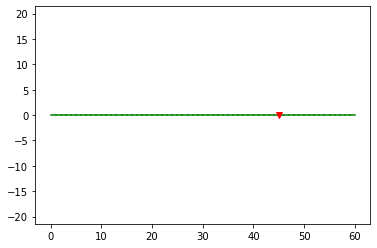

In [5]:
# plot the undeformed wire
plt.figure()
for iElem in np.arange(0, nElem):
    NodeLeft = int(Element[iElem, 0])
    NodeRight = int(Element[iElem, 1])

    plt.plot([NodeCoord[NodeLeft][0], NodeCoord[NodeRight][0]], [NodeCoord[NodeLeft][1], NodeCoord[NodeRight][1]], 'g')
    
# plot the supports
plt.plot(D, 0, 'vr')
plt.axis('equal')

Note that the distance between supports is smaller than the string length. Therefore, the final string position will take a catenary shape between these two points.

## Step 2: Dynamic system:

In this tutorial we assume that we have a string that initially is at its static equilibrium position. Then, we add a mass on the left of the string and release the left support.

#### Step 2.1: Find the initial static position

In order to get the initial string shape, we solve a static problem as done in tutorial 8.

Iteration: 1 ...































Iteration: 2 ...























Iteration: 3 ...
















Iteration: 4 ...



Iteration: 5 ...

Iteration: 6 ...

Iteration: 7 ...

Iteration: 8 ...

Iteration: 9 ...

Iteration: 10 ...

Iteration: 11 ...

Iteration: 12 ...


Iteration: 13 ...

Iteration: 14 ...

Iteration: 15 ...

Iteration: 16 ...

Iteration: 17 ...

Iteration: 18 ...

Iteration: 19 ...

Iteration: 20 ...

Iteration: 21 ...

Iteration: 22 ...

Iteration: 23 ...

Iteration: 24 ...

Iteration: 25 ...

Iteration: 26 ...

Iteration: 27 ...

Iteration: 28 ...

Iteration: 29 ...

Iteration: 30 ...

Converged solution at iteration: 30


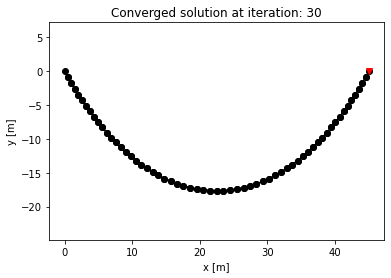

In [6]:
nDof = 2*nNode                          # number of DOFs
FreeDof = np.arange(0, nDof)            # free DOFs 
FixedDof = [0,1, -2, -1]                # fixed DOFs
FreeDof = np.delete(FreeDof, FixedDof)  # remove the fixed DOFs from the free DOFs array

# free & fixed array indices
fx = FreeDof[:, np.newaxis]
fy = FreeDof[np.newaxis, :]

SAG = 20                            # Let us assume a big sag - this will assure that all elements
                                    # are under tension, which may be necesary for the convergence
                                    # of the solver
s = np.array([i[0] for i in NodeCoord])
x = D*(s/L)
y = -4*SAG*((x/D)-(x/D)**2)
u = np.zeros((nDof))
u[0:nDof+1:2] = x - np.array([i[0] for i in NodeCoord])
u[1:nDof+1:2] = y - np.array([i[1] for i in NodeCoord])
# The displacement of the node corresponds to the actual position minus the initial position
# Remember that we use a Global Coordinate System (GCS) here.

Pext = np.zeros((nDof))
for iElem in np.arange(0, nElem):
    NodeLeft = int(Element[iElem, 0])
    NodeRight = int(Element[iElem, 1])
    DofsLeft = 2*NodeLeft 
    DofsRight = 2*NodeRight
    l0 = Element[iElem, 4]
    m = Element[iElem, 2]
    Pelem = -g*l0*m/2           # Half weight to each node
    Pext[DofsLeft + 1] += Pelem
    Pext[DofsRight + 1] += Pelem

from StringForcesAndStiffness import StringForcesAndStiffness
# Convergence parameters
CONV = 0
PLOT = False
kIter = 0
nMaxIter = 100
TENSION = np.zeros((nElem))

while CONV == 0:
    kIter += 1
    print("Iteration: "+str(kIter)+" ...\n")
    # Check stability - define a number of maximum iterations. If solution
    # hasn't converged, check what is going wrong (if something).
    if kIter > nMaxIter:
        break
    
    # Assemble vector with internal forces and stiffnes matrix
    K = np.zeros((nDof*nDof)) 
    Fi = np.zeros((nDof))
    for iElem in np.arange(0, nElem):
        NodeLeft = int(Element[iElem, 0])
        NodeRight = int(Element[iElem, 1])
        DofsLeft = 2*NodeLeft 
        DofsRight = 2*NodeRight
        l0 = Element[iElem, 4]
        EA = Element[iElem, 3]
        NodePos = ([NodeCoord[NodeLeft][0] + u[DofsLeft], NodeCoord[NodeRight][0] + u[DofsRight]], 
                    [NodeCoord[NodeLeft][1] + u[DofsLeft + 1], NodeCoord[NodeRight][1] + u[DofsRight + 1]])
        Fi_elem, K_elem, Tension, WARN = StringForcesAndStiffness(NodePos, EA, l0, TENSION_ONLY)
        TENSION[iElem] = Tension


        if WARN:
            print("WARNING: Element "+str(iElem+1)+" is under compression.\n")
        
        Fi[DofsLeft:DofsLeft + 2] += Fi_elem[0]
        Fi[DofsRight:DofsRight + 2] += Fi_elem[1]

        # Assemble the matrices at the correct place
            # Get the degrees of freedom that correspond to each node
        Dofs_Left = 2*(NodeLeft) + np.arange(0, 2)
        Dofs_Right = 2*(NodeRight) + np.arange(0, 2)
        nodes = np.append(Dofs_Left , Dofs_Right)
        for i in np.arange(0, 4):
            for j in np.arange(0, 4):
                ij = nodes[i] + nodes[j]*nDof
                K[ij] = K[ij] + K_elem[i, j]

    K = K.reshape((nDof, nDof))

    # Calculate residual forces
    R = Pext - Fi

    # Check for convergence
    if np.linalg.norm(R[FreeDof])/np.linalg.norm(Pext[FreeDof]) < 1e-3:
        CONV = 1

    # Calculate increment of displacements
    du = np.zeros((nDof))
    du[FreeDof] = np.linalg.solve(K[fx, fy], R[FreeDof])

    # Apply archlength to help with convergence
    Scale = np.min(np.append(np.array([1]), lElem/np.max(np.abs(du))))
    du = du*Scale   # Enforce that each node does not displace
                    # more (at each iteration) than the length
                    # of the elements

    # Update displacement of nodes
    u += du

    # plot the updated configuration
    if PLOT:
        for iElem in np.arange(0, nElem):
            NodeLeft = int(Element[iElem, 0])
            NodeRight = int(Element[iElem, 1])
            DofsLeft = 2*NodeLeft 
            DofsRight = 2*NodeRight
            plt.plot([NodeCoord[NodeLeft][0] + u[DofsLeft], NodeCoord[NodeRight][0] + u[DofsRight]], 
                        [NodeCoord[NodeLeft][1] + u[DofsLeft + 1], NodeCoord[NodeRight][1] + u[DofsRight + 1]], '-ok')
            
        # plot the supports
        plt.plot([0, D], [0, 0], 'vr')
        plt.axis('equal')
        plt.xlabel("x [m]")
        plt.ylabel("y [m]")
        plt.title("Iteration: "+str(kIter))
        plt.pause(0.05)

if CONV == 1:
    print("Converged solution at iteration: "+str(kIter))
    for iElem in np.arange(0, nElem):
            NodeLeft = int(Element[iElem, 0])
            NodeRight = int(Element[iElem, 1])
            DofsLeft = 2*NodeLeft 
            DofsRight = 2*NodeRight
            plt.plot([NodeCoord[NodeLeft][0] + u[DofsLeft], NodeCoord[NodeRight][0] + u[DofsRight]], 
                        [NodeCoord[NodeLeft][1] + u[DofsLeft + 1], NodeCoord[NodeRight][1] + u[DofsRight + 1]], '-ok')
            
    # plot the supports
    plt.plot(D, 0, 'vr')
    plt.axis('equal')
    plt.xlabel("x [m]")
    plt.ylabel("y [m]")
    plt.title("Converged solution at iteration: "+str(kIter))
else:
    print("Solution did not converge")

#### Step 2.2: solve the dynamic problem

First, we define the mass on the left node and some damping. 

In [7]:
Mass = 100
C = 0.001*EA

The external force will be the same as the one used to find the initial position, so here we only need to compute the mass matrix.

In [8]:
M = np.zeros((nDof*nDof))
M[0] = Mass                         # Add mass at the left node
M[nDof + 1] = Mass                  # Add mass at the left node
Pext[1] = Pext[1] - Mass*g          # Add weight to the left node
for iElem in np.arange(0, nElem):
        NodeLeft = int(Element[iElem, 0])
        NodeRight = int(Element[iElem, 1])
        DofsLeft = 2*NodeLeft 
        DofsRight = 2*NodeRight
        l0 = Element[iElem, 4]
        EA = Element[iElem, 3]
        M_elem = m*l0/6*np.array([[2, 0, 1, 0], 
                                    [0, 2, 0, 1], 
                                    [1, 0, 2, 0], 
                                    [0, 1, 0, 2]])
        # Assemble the matrices at the correct place
        # Get the degrees of freedom that correspond to each node
        Dofs_Left = 2*(NodeLeft) + np.arange(0, 2)
        Dofs_Right = 2*(NodeRight) + np.arange(0, 2)
        nodes = np.append(Dofs_Left , Dofs_Right)
        for i in np.arange(0, 4):
            for j in np.arange(0, 4):
                ij = nodes[i] + nodes[j]*nDof
                M[ij] = M[ij] + M_elem[i, j]
M = M.reshape((nDof, nDof))

We define the fixed and free DOFs of the system.

In [9]:
# Release the left support
nDof = 2*nNode                          # number of DOFs
FreeDof = np.arange(0, nDof)            # free DOFs 
FixedDof = [-2, -1]                     # fixed DOFs
FreeDof = np.delete(FreeDof, FixedDof)  # remove the fixed DOFs from the free DOFs array

# free & fixed array indices
fx = FreeDof[:, np.newaxis]
fy = FreeDof[np.newaxis, :]

Now, we have all we need to perform the time integration. We initialize the state vector with zero initial velocities. To solve the ODE we use the `solve_ivp` function, calling the `ACCELERATIONS` function as an ode function. You can find the definition of this function below.

##### Auxiliar function:

The `ACCELERATIONS` function computes the accelerations based on the equation:

$$ \bold{M} \ddot{\bold{u}}_{n+1} = \bold{F}_{ext} - \bold{F}_{int}(\bold{u}_n, \dot{\bold{u}}_n) $$

In [10]:
from StringDynamicForces import StringDynamicForces
def ACCELERATIONS(t, U, NodeCoord, Element, FreeDof, C, M, Pext, TENSION_ONLY):
    nDof = len(U)
    u = U[:nDof//2]
    v = U[nDof//2:]

    # free & fixed array indices
    fx = FreeDof[:, np.newaxis]
    fy = FreeDof[np.newaxis, :]

    # Calculate internal forces
    FintDyn = np.zeros((nDof))
    for iElem in np.arange(0, len(Element)):
        NodeLeft = int(Element[iElem, 0])
        NodeRight = int(Element[iElem, 1])
        DofsLeft = 2*NodeLeft 
        DofsRight = 2*NodeRight
        l0 = Element[iElem, 4]
        EA = Element[iElem, 3]
        NodePos = ([NodeCoord[NodeLeft][0] + u[DofsLeft], NodeCoord[NodeRight][0] + u[DofsRight]], 
            [NodeCoord[NodeLeft][1] + u[DofsLeft + 1], NodeCoord[NodeRight][1] + u[DofsRight + 1]])
        NodeVel = ([v[DofsLeft], v[DofsRight]], 
                    [v[DofsLeft + 1], v[DofsRight + 1]])
        Fint = StringDynamicForces(NodePos, NodeVel, EA, C, l0)
        FintDyn[DofsLeft:DofsLeft + 2] += Fint[0]
        FintDyn[DofsRight:DofsRight + 2] += Fint[1]

    # Calculate the new acceleration
    a = np.zeros((nDof//2))
    a[FreeDof] = np.linalg.solve(M[fx, fy], (Pext[FreeDof]-FintDyn[FreeDof]))
    
    # Store the derivative of phase
    dU = np.append(v, a)
    #print("Time = "+str(t)+" s")
    return dU


In [11]:
v = u*0
U0 = np.append(u, v)
dt = 0.1
Tend = 30
tspan = np.arange(0, Tend, dt)

def odefun(t, U):
    return ACCELERATIONS(t, U, NodeCoord, Element, FreeDof, C, M, Pext, TENSION_ONLY)

sol = scp.solve_ivp(fun=odefun, t_span=[tspan[0], tspan[-1]], y0=U0, t_eval=tspan)  


Once we have the solution, we can plot the evolution of the string.

Text(0, 0.5, 'y [m]')

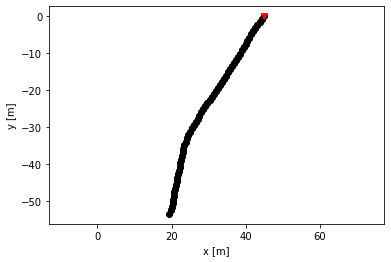

In [12]:
%matplotlib inline
import time
from IPython import display

for iT in np.arange(0, len(sol.t)):
    try: 
        u = sol.y[:nDof, iT]
        for iElem in np.arange(0, nElem):
            NodeLeft = int(Element[iElem, 0])
            NodeRight = int(Element[iElem, 1])
            DofsLeft = 2*NodeLeft 
            DofsRight = 2*NodeRight
            plt.plot([NodeCoord[NodeLeft][0] + u[DofsLeft], NodeCoord[NodeRight][0] + u[DofsRight]], 
                        [NodeCoord[NodeLeft][1] + u[DofsLeft + 1], NodeCoord[NodeRight][1] + u[DofsRight + 1]], '-ok')
        # plot the supports
        plt.plot(D, 0, 'vr')     
        plt.axis('equal')
        plt.xlabel("x [m]")
        plt.ylabel("y [m]")
        display.display(plt.gcf())
        display.clear_output(wait=True)
        plt.clf()
        time.sleep(0.1)
    except KeyboardInterrupt:
        break

u = sol.y[:nDof, -1]
for iElem in np.arange(0, nElem):
    NodeLeft = int(Element[iElem, 0])
    NodeRight = int(Element[iElem, 1])
    DofsLeft = 2*NodeLeft 
    DofsRight = 2*NodeRight
    plt.plot([NodeCoord[NodeLeft][0] + u[DofsLeft], NodeCoord[NodeRight][0] + u[DofsRight]], 
                [NodeCoord[NodeLeft][1] + u[DofsLeft + 1], NodeCoord[NodeRight][1] + u[DofsRight + 1]], '-ok')
# plot the supports
plt.plot(D, 0, 'vr')     
plt.axis('equal')
plt.xlabel("x [m]")
plt.ylabel("y [m]")
